1. *Task* 1

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 57007924.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


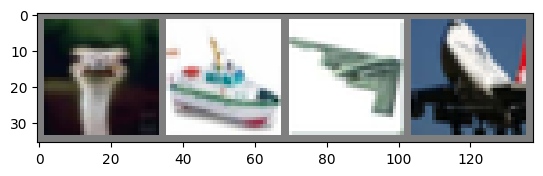

bird  ship  plane plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.206
[1,  4000] loss: 1.849
[1,  6000] loss: 1.670
[1,  8000] loss: 1.584
[1, 10000] loss: 1.513
[1, 12000] loss: 1.489
[2,  2000] loss: 1.427
[2,  4000] loss: 1.368
[2,  6000] loss: 1.327
[2,  8000] loss: 1.347
[2, 10000] loss: 1.307
[2, 12000] loss: 1.289
Finished Training


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
PATH = '/content/drive/My Drive/CV_Assign4_weights.pth'

In [9]:
torch.save(net.state_dict(), PATH)

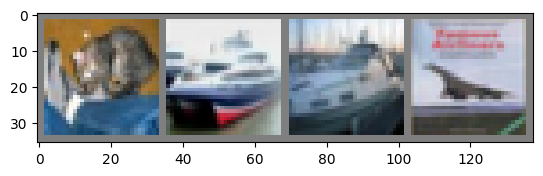

GroundTruth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.8 %
Accuracy for class: car   is 75.9 %
Accuracy for class: bird  is 41.8 %
Accuracy for class: cat   is 21.9 %
Accuracy for class: deer  is 44.5 %
Accuracy for class: dog   is 38.7 %
Accuracy for class: frog  is 76.1 %
Accuracy for class: horse is 73.2 %
Accuracy for class: ship  is 56.9 %
Accuracy for class: truck is 63.8 %


1. *Task* 2

In [41]:
testloader1 = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

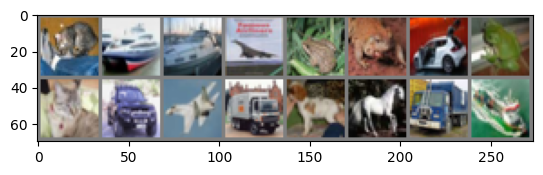

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [42]:
dataiter = iter(testloader1)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

In [43]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(16)))

Predicted:  cat   ship  ship  ship  deer  frog  car   frog  cat   car   deer  truck frog  horse truck car  


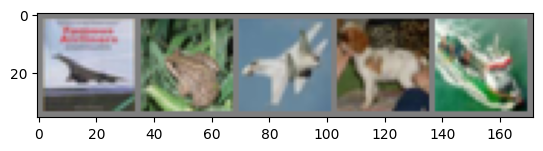

GroundTruth:  plane frog  plane dog   ship 


In [44]:
import torchvision

dataiter = iter(testloader1)
images, labels = next(dataiter)

# Define indices to exclude from display
exclude_indices = {0, 1, 2,5,6,7,8,9,11,13,14}

# Filter out images and labels at specified indices
filtered_images = [img for i, img in enumerate(images) if i not in exclude_indices]
filtered_labels = [label for i, label in enumerate(labels) if i not in exclude_indices]

# Print images
imshow(torchvision.utils.make_grid(filtered_images))
print('GroundTruth: ', ' '.join(f'{classes[filtered_labels[j]]:5s}' for j in range(len(filtered_labels))))


In [45]:
exclude_indices = {0, 1, 2,5,6,7,8,9,11,13,14}
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(16) if j not in exclude_indices))

Predicted:  ship  deer  deer  frog  car  


1. Task 3

In [21]:
#Change batch size
batch_size = 20

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [23]:

net1 = Net()
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#Change Learning Rate
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)

In [24]:
#Change Epochs
for epoch in range(15):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.146
[2,  2000] loss: 1.662
[3,  2000] loss: 1.477
[4,  2000] loss: 1.352
[5,  2000] loss: 1.254
[6,  2000] loss: 1.175
[7,  2000] loss: 1.124
[8,  2000] loss: 1.076
[9,  2000] loss: 1.036
[10,  2000] loss: 0.993
[11,  2000] loss: 0.961
[12,  2000] loss: 0.931
[13,  2000] loss: 0.894
[14,  2000] loss: 0.865
[15,  2000] loss: 0.840
Finished Training


In [25]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net1(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


1. Task 5

In [26]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from PIL import Image

# Load the MNIST dataset
mnist_dataset = MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())
mnist_img, _ = mnist_dataset[0]  # Get an MNIST image and its label

# Display the MNIST image
transforms.ToPILImage()(mnist_img).show()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34135446.84it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1106625.87it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10813565.32it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4784160.92it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [27]:
# MNIST to CIFAR transform
transform_cifar = transforms.Compose([
    transforms.Resize(32),  # Resize to 32x32 to match CIFAR-10 dimensions
    transforms.ToPILImage(),  # Convert to PIL image to apply the next transformation
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize like CIFAR-10
])

# Apply the transform
mnist_img_cifar = transform_cifar(mnist_img)


net.eval()
with torch.no_grad():
    mnist_img_cifar = mnist_img_cifar.unsqueeze(0)  # Add batch dimension
    outputs = net(mnist_img_cifar)  # Predict
    _, predicted = torch.max(outputs, 1)  # Get the predicted class

# Output the prediction
print(f'Predicted CIFAR-10 class: {predicted.item()}')
print(classes[predicted])

Predicted CIFAR-10 class: 2
bird


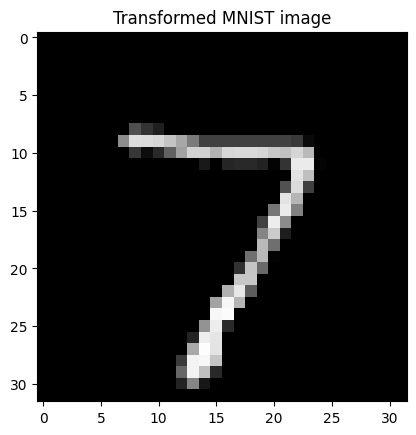

In [28]:
# Visualize the image
# Squeeze the batch dimension and transpose the image for correct display
img_to_show = mnist_img_cifar.squeeze().permute(1, 2, 0)  # From (C, H, W) to (H, W, C)

plt.imshow(img_to_show)
plt.title('Transformed MNIST image')
plt.show()
